In [1]:
#@title Imports
import torch
from torchvision import datasets, transforms , models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary
import random
import time
import os

In [15]:
#@title Global Variables
BATCH_SIZE = 32
STUDENT_EPOCH = 1
TEACHER_EPOCHS = 1
ALPHA=0.5
TEMPERATURE=2
STUDENT_LR = 1e-4
TEACHER_LR = 1e-4
OUT_CLASSES = 10
PATCH_SIZE = 16
IMAGE_SIZE = (224,224)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# @title Dataset (USING CIFAR-10)
import kagglehub
path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

Using Colab cache for faster access to the 'cifar10-pngs-in-folders' dataset.


In [4]:
!ls {path}/cifar10/cifar10/train

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


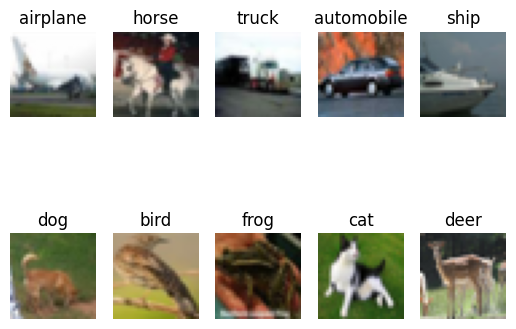

In [5]:
# @title Demo images
# randomly selecting 1 image from each class for preview
all_classes=os.listdir(f"{path}/cifar10/cifar10/train")
demo_images=[f"{path}/cifar10/cifar10/train/{i}/"+random.sample(os.listdir(f"{path}/cifar10/cifar10/train/{i}"),1)[0] for i in all_classes]

for i in range(len(demo_images)):
  plt.subplot(2,5,i+1)
  plt.imshow(plt.imread(demo_images[i]))
  plt.axis('off')
  plt.title(all_classes[i])
plt.show()

In [6]:
# @title Data loader
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(root=f"{path}/cifar10/cifar10/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{path}/cifar10/cifar10/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
plt.imread(demo_images[0])

array([[[1.        , 1.        , 1.        ],
        [0.98039216, 0.98039216, 0.9764706 ],
        [0.9882353 , 0.9843137 , 0.9764706 ],
        ...,
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        [0.9843137 , 0.9843137 , 0.9843137 ]],

       [[1.        , 1.        , 1.        ],
        [0.96862745, 0.96862745, 0.972549  ],
        [0.9882353 , 0.9882353 , 0.99215686],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.95686275, 0.95686275, 0.9607843 ],
        [0.84313726, 0.8509804 , 0.85882354],
        [0.8862745 , 0.8980392 , 0.9098039 ],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686]],

       ...,

       [[0.24313726, 0.28235295, 0.13333334],
        [0.24705882, 0.28235295, 0.13725491],
        [0.24705882, 0

In [8]:
train_dataset.class_to_idx,test_dataset.class_to_idx

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

In [9]:
#@title Teacher model (resnet 50)
teacher_model=models.resnet50(pretrained=True)
teacher_model.fc=nn.Linear(teacher_model.fc.in_features,OUT_CLASSES)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [12]:
# @title Freezing base model

# freezing layers other than fc
for param in teacher_model.parameters():
  param.requires_grad=False
for param in teacher_model.fc.parameters():
  param.requires_grad=True

teacher_model.to(device)
summary(teacher_model,input_size=(3,*IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
# @title loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(teacher_model.parameters(),lr=TEACHER_LR)

In [16]:
# @title Fine tunning teacher model for CIFAR 10
teacher_model.to(device)

for epochs in range(TEACHER_EPOCHS):
  total_loss=0
  total_correct=0
  total=0
  start_time=time.time()
  for x_batch,y_batch in tqdm(train_loader):
    x_batch,y_batch=x_batch.to(device),y_batch.to(device)
    total+=len(y_batch)

    # forward_pass
    y_pred=teacher_model(x_batch)
    loss=loss_fn(y_pred,y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    total_correct+=(y_pred.argmax(dim=1)==y_batch).sum().item()

  print(f"time taken in epoch {epochs} is {time.time()-start_time} ,loss is {total_loss}, accuracy is {total_correct/total}")

100%|██████████| 1563/1563 [05:57<00:00,  4.38it/s]

time taken in epoch 0 is 357.2015872001648 ,loss is 1630.6690909266472, accuracy is 0.72296


In [17]:
# @title Patchify function

# this function take a batch of images and convert them into patches of patch_size

def Patchify(x, patch_size):
    # x: (B, C, H, W)
    B, C, H, W = x.shape
    p = patch_size

    # reshape + permute trick
    x = x.reshape(B, C, H//p, p, W//p, p)
    x = x.permute(0, 2, 4, 1, 3, 5)       # (B, H/p, W/p, C, p, p)

    patches = x.reshape(B, (H//p)*(W//p), C*p*p)
    return patches

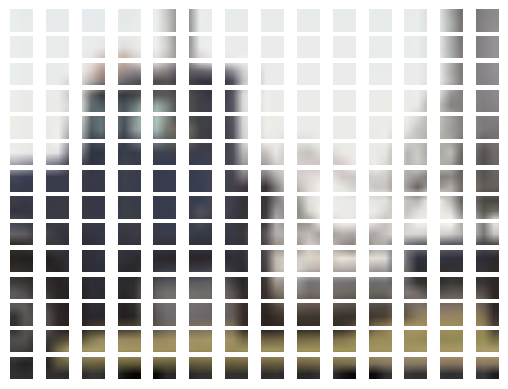

In [18]:
img=next(iter(train_loader))[0]
img_patches=Patchify(img,PATCH_SIZE)[0]
# visualising patches
for i in range(1,197):
  plt.subplot(14,14,i)
  t_img=img_patches[i-1]
  t_img=torch.reshape(t_img,[3,16,16]).permute((1,2,0))
  plt.imshow(t_img.numpy())
  plt.axis("off")
plt.show()

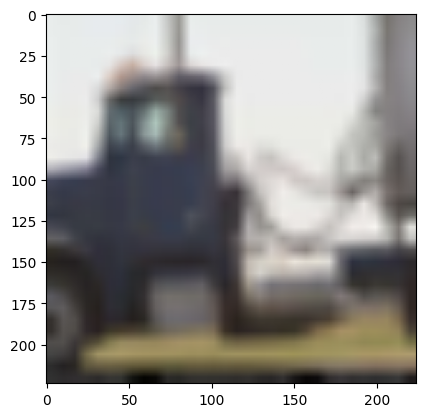

In [19]:
plt.imshow(img[0].permute(1,2,0).numpy())

In [20]:
# @title Patches Embedding
class PatchEmbed(nn.Module):
  def __init__(self,projection_dim=192,channels=3,patch_size=16,num_patches=196,device=device):
    super().__init__()

    self.projection_dim=projection_dim
    self.patch_size=patch_size
    self.num_patches=num_patches
    self.device=device

    self.cls=nn.Parameter(torch.randn(1, projection_dim),requires_grad=True)
    self.distil=nn.Parameter(torch.randn(1, projection_dim),requires_grad=True)

    self.projection=nn.Linear(channels*patch_size*patch_size,projection_dim)

    self.pos_embedding=nn.Embedding(num_patches+2,projection_dim)

  def forward(self,x):
    batch_size=x.shape[0]

    cls=self.cls.expand(batch_size,-1).reshape(batch_size,1,self.projection_dim)
    distil=self.distil.expand(batch_size,-1).reshape(batch_size,1,self.projection_dim)

    x=Patchify(x,self.patch_size)
    x=self.projection(x)
    x=torch.cat((cls,x,distil),dim=1)

    # postional embedding
    pos_embedding=torch.arange(0,self.num_patches+2,device=self.device)
    pos_embedding=self.pos_embedding(pos_embedding)
    x=x+pos_embedding

    return x

In [26]:
lr=PatchEmbed().to(device)
lr_out=lr(next(iter(train_loader))[0].to(device))
lr_out.shape

torch.Size([32, 198, 192])

In [27]:
# @title MLP
class MLP(nn.Module):
  def __init__(self,input_features,hidden_features,output_features,dropout_rate=0.1):
    super().__init__()

    self.seq=nn.Sequential(
            nn.Linear(input_features,hidden_features),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_features,output_features),
            nn.Dropout(dropout_rate),
            )

  def forward(self,x):
    return self.seq(x)

In [29]:
mlp=MLP(192,192*2,192).to(device)
mlp(lr_out).shape

torch.Size([32, 198, 192])

In [30]:
# @title Encoder block
class Block(nn.Module):
  def __init__(self,projection_dim=192,num_heads=3,dropout_rate=0.1):
    super().__init__()
    self.mlp=MLP(projection_dim,projection_dim*2,projection_dim)
    self.layernorm1=nn.LayerNorm(projection_dim)
    self.layernorm2=nn.LayerNorm(projection_dim)
    self.mha=nn.MultiheadAttention(projection_dim,num_heads,dropout=dropout_rate, batch_first=True)

  def forward(self,x):
    x=self.layernorm1(x)
    attention_output,_=self.mha(x,x,x)
    x=x+attention_output
    x=self.layernorm2(x)
    mlp_output=self.mlp(x)
    x=x+mlp_output
    return x

In [31]:
class VT(nn.Module):
  def __init__(self,projection_dim=192, num_heads=3, num_blocks=12, dropout_rate=0.1,output_features=10):
    super().__init__()
    self.patches=PatchEmbed(projection_dim)
    self.blocks=nn.ModuleList([Block(projection_dim,num_heads,dropout_rate) for _ in range(num_blocks)])
    self.norm=nn.LayerNorm(projection_dim)
    self.dropout=nn.Dropout(dropout_rate)

    self.fc_distill=nn.Linear(projection_dim,output_features)
    self.fc_cls=nn.Linear(projection_dim,output_features)

  def forward(self,x):
    x=self.patches(x)
    for blk in self.blocks:
      x=blk(x)
    x=self.norm(x)
    x=self.dropout(x)

    cls=x[:,0,:]
    distil=x[:,-1,:]

    return self.fc_cls(cls),self.fc_distill(distil)

In [33]:
vt=VT().to(device)
a,b=vt(next(iter(train_loader))[0].to(device))
a.shape,b.shape

(torch.Size([32, 10]), torch.Size([32, 10]))

In [43]:
# @title Define student model
student_model=VT().to(device)
student_optimizer=optim.AdamW(student_model.parameters(),lr=STUDENT_LR)
summary(student_model,input_size=(3,*IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 196, 192]         147,648
         Embedding-2                  [-1, 192]          38,016
        PatchEmbed-3             [-1, 198, 192]               0
         LayerNorm-4             [-1, 198, 192]             384
MultiheadAttention-5  [[-1, 198, 192], [-1, 198, 198]]               0
         LayerNorm-6             [-1, 198, 192]             384
            Linear-7             [-1, 198, 384]          74,112
              GELU-8             [-1, 198, 384]               0
           Dropout-9             [-1, 198, 384]               0
           Linear-10             [-1, 198, 192]          73,920
          Dropout-11             [-1, 198, 192]               0
              MLP-12             [-1, 198, 192]               0
            Block-13             [-1, 198, 192]               0
        LayerNorm-14            

In [40]:
# @title Loss function <br> <img src="https://i.postimg.cc/7hnfTfxV/image.png">
cls_loss_fn=nn.CrossEntropyLoss()
def kd_loss(cls_logit,distill_logits,t_logits,y_true,alpha=ALPHA,temperature=TEMPERATURE):
  cls_loss=cls_loss_fn(cls_logit,y_true)
  distill_loss=nn.functional.kl_div(nn.functional.softmax(distill_logits/temperature,dim=1),nn.functional.softmax(t_logits/temperature,dim=1))*(temperature**2)
  return alpha*cls_loss+(1-alpha)*distill_loss


In [41]:
def train_batch(x,y,student_model,teacher_model,student_optimizer,loss_fn):
  x=x.to(device)
  y=y.to(device)

  cls_logits,distill_logits=student_model(x)
  with torch.no_grad():
    t_cls_logits=teacher_model(x)

  loss=loss_fn(cls_logits,distill_logits,t_cls_logits,y)

  student_optimizer.zero_grad()
  loss.backward()
  student_optimizer.step()

  return loss.item()

In [42]:
for epoch in range(1,STUDENT_EPOCH+1):
  loss=0
  start_time=time.time()
  for x_batch,y_batch in tqdm(train_loader):
    loss+=train_batch(x_batch,y_batch,student_model,teacher_model,student_optimizer,kd_loss)
  print(f"Epoch no {epoch}, time = {time.time()-start_time}")


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:3355: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 1563/1563 [06:43<00:00,  3.88it/s]

Epoch no 1, time = 403.2185468673706
